## Take- Home Challenge : Ultimate Technologies Inc.

__Introduction:__

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.


__Data description:__

- city: city this user signed up in
- phone: primary device for this user
- signup_date: date of account registration; in the form ‘YYYY MM DD’
- last_trip_date: the last time this user completed a trip; in the form ‘YYYY MM DD’
- avg_dist: the average distance in miles per trip taken in the first 30 days after signup
- avg_rating_by_driver: the rider’s average rating over all of their trips
- avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
- surge_pct: the percent of trips taken with surge multiplier > 1
- avg_surge: The average surge multiplier over all of this user’s trips
- trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
- ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise
- weekday_pct: the percent of the user’s trips occurring during a weekday

__Objective:__

1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
  
  - How you will implement the experiment
  - What statistical test(s) you will conduct to verify the significance of the observation
  - How you would interpret the results and provide recommendations to the city operations team along with any caveats.

In [1]:
# importing neccessary libraries:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score


In [2]:
# Loading the login.json dataset

logins_df= pd.read_json('logins.json')
logins_df.head(5)

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
logins_df= logins_df.sort_values("login_time")
logins_df= logins_df.reset_index(drop= True)
logins_df.head()

,login_time
0,1970-01-01 20:12:16
1,1970-01-01 20:13:18
2,1970-01-01 20:16:10
3,1970-01-01 20:16:36
4,1970-01-01 20:16:37


In [4]:
logins_df.dtypes

login_time    datetime64[ns]
dtype: object

In [5]:
logins_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [6]:
logins_df.isnull().sum()

login_time    0
dtype: int64

In [7]:
logins_df.describe()

,login_time
count,93142
unique,92265
top,1970-04-04 01:17:40
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


In [8]:
# Aggregating these login counts based on 15 minute time intervals

date_range= pd.date_range('1970-01-01 20:00:00', '1970-04-13 19:00:00', freq='15T')
logins_df_ser= pd.Series(np.zeros(len(date_range)), index= date_range)
logins_df_ser.head()

1970-01-01 20:00:00    0.0
1970-01-01 20:15:00    0.0
1970-01-01 20:30:00    0.0
1970-01-01 20:45:00    0.0
1970-01-01 21:00:00    0.0
Freq: 15T, dtype: float64

In [9]:
## Checking how many customers signed up in every 15 min interval

p=0

for i in range(len(logins_df)):
    start_time= logins_df_ser.index[p]
    end_time= logins_df_ser.index[p+1]
    t= logins_df['login_time'][i]
    
    if start_time < t < end_time:
        logins_df_ser[p] = logins_df_ser[p] + 1
        
    else:
        while(end_time < t):
            p= p+1
            start_time= logins_df_ser.index[p]
            end_time= logins_df_ser.index[p+1]
            
        logins_df_ser[p]= logins_df_ser[p] + 1

In [10]:
logins_df_ser.head()

1970-01-01 20:00:00    2.0
1970-01-01 20:15:00    6.0
1970-01-01 20:30:00    9.0
1970-01-01 20:45:00    7.0
1970-01-01 21:00:00    1.0
Freq: 15T, dtype: float64

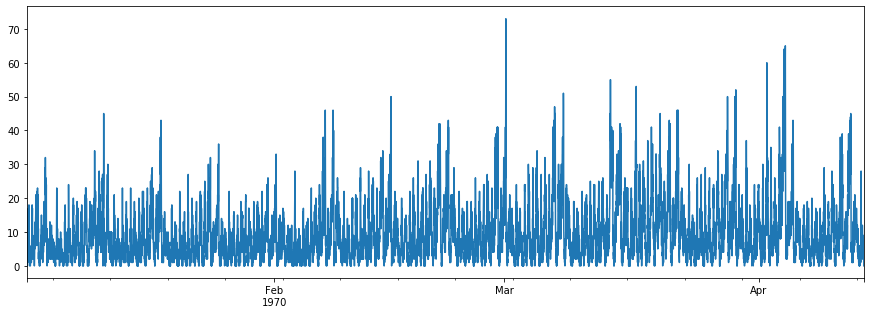

In [11]:
plt.figure(figsize=(15,5))
logins_df_ser.plot()

It seems the activity take its peak during weekends and keeps on rising during the weekdays subsequently.Some data qualities issues were present like the login times were randomly organized, So, I need to sort them.

In [12]:
## Loading the 2nd dataset

import json
with open(r'C:\Users\user\Desktop\Springboard\Curriculum Projects\ultimate_challenge/ultimate_data_challenge.json') as f:
    data = json.load(f)

ultimate_df = pd.DataFrame(data)
ultimate_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


### Data cleaning and pre-processing

In [13]:
ultimate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null object
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null object
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [14]:
# removing null values

ultimate_df['avg_rating_of_driver'].value_counts()

5.0    20771
4.0     4193
4.5     2498
4.8     2430
4.7     1945
4.9     1771
4.3     1487
4.6     1143
3.0     1003
4.4      829
4.2      601
3.5      488
3.8      428
4.1      398
3.7      364
1.0      256
3.9      255
2.0      209
3.3      201
3.6      172
3.4      108
2.5       94
3.2       53
2.7       47
3.1       39
2.8       28
2.3       22
2.9       13
2.6       12
2.1        6
1.5        4
2.4        3
1.8        2
1.7        2
2.2        1
1.6        1
1.9        1
Name: avg_rating_of_driver, dtype: int64

In [15]:
## Replacing the null values by replacing it with median of the column

ultimate_df['avg_rating_of_driver'].median()

4.9

In [16]:
ultimate_df['avg_rating_of_driver'].fillna(4.9, inplace= True)

In [17]:
ultimate_df['avg_rating_of_driver'].value_counts()

5.0    20771
4.9     9893
4.0     4193
4.5     2498
4.8     2430
4.7     1945
4.3     1487
4.6     1143
3.0     1003
4.4      829
4.2      601
3.5      488
3.8      428
4.1      398
3.7      364
1.0      256
3.9      255
2.0      209
3.3      201
3.6      172
3.4      108
2.5       94
3.2       53
2.7       47
3.1       39
2.8       28
2.3       22
2.9       13
2.6       12
2.1        6
1.5        4
2.4        3
1.8        2
1.7        2
2.2        1
1.6        1
1.9        1
Name: avg_rating_of_driver, dtype: int64

In [18]:
## Replacing the null values by replacing it with median of column

ultimate_df['avg_rating_by_driver'].median()

5.0

In [19]:
ultimate_df['avg_rating_by_driver'].fillna(5.0, inplace= True)

In [20]:
ultimate_df['avg_rating_by_driver'].isnull().sum()

0

In [21]:
ultimate_df['phone'].value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

In [22]:
ultimate_df['phone'].fillna('iPhone', inplace= True)
ultimate_df['phone'].value_counts()

iPhone     34978
Android    15022
Name: phone, dtype: int64

In [23]:
ultimate_df.isnull().sum()

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
dtype: int64

In [24]:
## Converting the columns having dates in it to datetime format.

ultimate_df['signup_date']=pd.to_datetime(ultimate_df['signup_date'], format="%Y/%m/%d")
ultimate_df['last_trip_date']=pd.to_datetime(ultimate_df['last_trip_date'], format="%Y/%m/%d")

In [25]:
ultimate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null datetime64[ns]
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null datetime64[ns]
phone                     50000 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


In [26]:
## Creating a column named "active" to check if any customer was active prior to a month before 180 days of the sign up date.

user_active = []
for i in range(len(ultimate_df)):
    start_time = pd.Timestamp(ultimate_df['signup_date'][i])
    end_time = start_time + pd.Timedelta('181D')
    active_time = end_time - pd.Timedelta('30D')
    if active_time <= pd.Timestamp(ultimate_df['last_trip_date'][i]) <= end_time:
        user_active.append(1)
    else:
        user_active.append(0)
    
    
user_active

[0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [27]:
df_temp = pd.DataFrame(user_active,columns = ['active'])
df_temp.head()

,active
0,0
1,0
2,0
3,1
4,0


In [28]:
df_temp['active'].value_counts()

0    37802
1    12198
Name: active, dtype: int64

In [29]:
# proportion of customers active

proportion= (df_temp[df_temp['active']== 1].sum()/ df_temp['active'].value_counts().sum())*100
proportion

active    24.396
dtype: float64

In [30]:
ub_active = pd.crosstab(index=df_temp["active"], 
                            columns=ultimate_df["ultimate_black_user"],
                             margins=True) 

ub_active.columns = ["Not Ultimate Black","Ultimate Black","Total"]
ub_active.index= ["Not Active","Active","Total"]

ub_active

,Not Ultimate Black,Ultimate Black,Total
Not Active,25204,12598,37802
Active,5942,6256,12198
Total,31146,18854,50000


Proportion of Utimate black users who were active. i.e. (12598/18854)= 0.6872 (68.72%). So, it seems to be a major feature.



In [31]:
phone_active = pd.crosstab(index=df_temp["active"], 
                            columns=ultimate_df["phone"],
                             margins=True)

phone_active.columns = ["Android","iPhone","Total"]
phone_active.index= ["Not Active","Active","Total"]

phone_active

,Android,iPhone,Total
Not Active,13096,24706,37802
Active,1926,10272,12198
Total,15022,34978,50000


- Proportion of Android users who were active. i.e. (13096/15022)= 0.8717 (87.17%). So, it seems to be a major feature.
- Proportion of iPhone users who were active. i.e. (24706/34975)= 0.7100 (71.00%). So, it seems to be a major feature.

In [32]:
city_active = pd.crosstab(index=df_temp["active"], 
                            columns=ultimate_df["city"],
                             margins=True)
city_active.columns = ["Astapor","King's Landing",'Winterfell',"Total"]
city_active.index= ["Not Active","Active","Total"]

city_active

,Astapor,King's Landing,Winterfell,Total
Not Active,13838,6099,17865,37802
Active,2696,4031,5471,12198
Total,16534,10130,23336,50000


- Proportion of users who live in Astapor were active. i.e. (13838/16534)= 0.8369 (83.69%). So, it seems to be a major feature.
- Proportion of users who live in King's Landing were active. i.e. (6099/10130)= 0.6020 (60.20%). So, it seems to be a major feature.
- Proportion of users who live in Winterfell were active. i.e. (17865/23336)= 0.7655 (76.55%). So, it seems to be a major feature.

In [33]:
## dealing with categorical variables

df_categorical= ultimate_df.copy()
df_categorical

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49996,Astapor,1,2014-01-24,4.9,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0
49998,Astapor,2,2014-01-14,3.0,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5


In [34]:
df_categorical.drop(['city','trips_in_first_30_days','signup_date', 'avg_rating_of_driver', 'avg_surge', 'last_trip_date', 'surge_pct', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver'], axis= 1, inplace= True)

In [35]:
df_categorical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
phone                  50000 non-null object
ultimate_black_user    50000 non-null bool
dtypes: bool(1), object(1)
memory usage: 439.6+ KB


In [36]:
df_categorical['ultimate_black_user']=list(map(int, df_categorical['ultimate_black_user']))
df_categorical

,phone,ultimate_black_user
0,iPhone,1
1,Android,0
2,iPhone,0
3,iPhone,1
4,Android,0
...,...,...
49995,iPhone,0
49996,iPhone,0
49997,Android,1
49998,iPhone,0


In [37]:
## Creating dummy variables for nominal categorical variables.

df_temp_2=pd.get_dummies(df_categorical)
df_temp_2.head()

,ultimate_black_user,phone_Android,phone_iPhone
0,1,0,1
1,0,1,0
2,0,0,1
3,1,0,1
4,0,1,0


In [38]:
ultimate_df.drop(['ultimate_black_user', 'phone'], axis= 1, inplace= True)

In [39]:
ultimate_df['active']= df_temp['active']
ultimate_df['phone_Android']= df_temp_2['phone_Android']
ultimate_df['phone_iPhone']= df_temp_2['phone_iPhone']
ultimate_df['ultimate_black_user']= df_temp_2['ultimate_black_user']
ultimate_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,active,phone_Android,phone_iPhone,ultimate_black_user
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,15.4,46.2,3.67,5.0,0,0,1,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,0.0,50.0,8.26,5.0,0,1,0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,0.0,100.0,0.77,5.0,0,0,1,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,20.0,80.0,2.36,4.9,1,0,1,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,11.8,82.4,3.13,4.9,0,1,0,0


In [40]:
df_for_corr= ultimate_df.copy()
df_for_corr.drop(['city', 'signup_date', 'last_trip_date'], axis= 1, inplace= True)
df_for_corr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
trips_in_first_30_days    50000 non-null int64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
surge_pct                 50000 non-null float64
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
active                    50000 non-null int64
phone_Android             50000 non-null uint8
phone_iPhone              50000 non-null uint8
ultimate_black_user       50000 non-null int64
dtypes: float64(6), int64(3), uint8(2)
memory usage: 3.5 MB


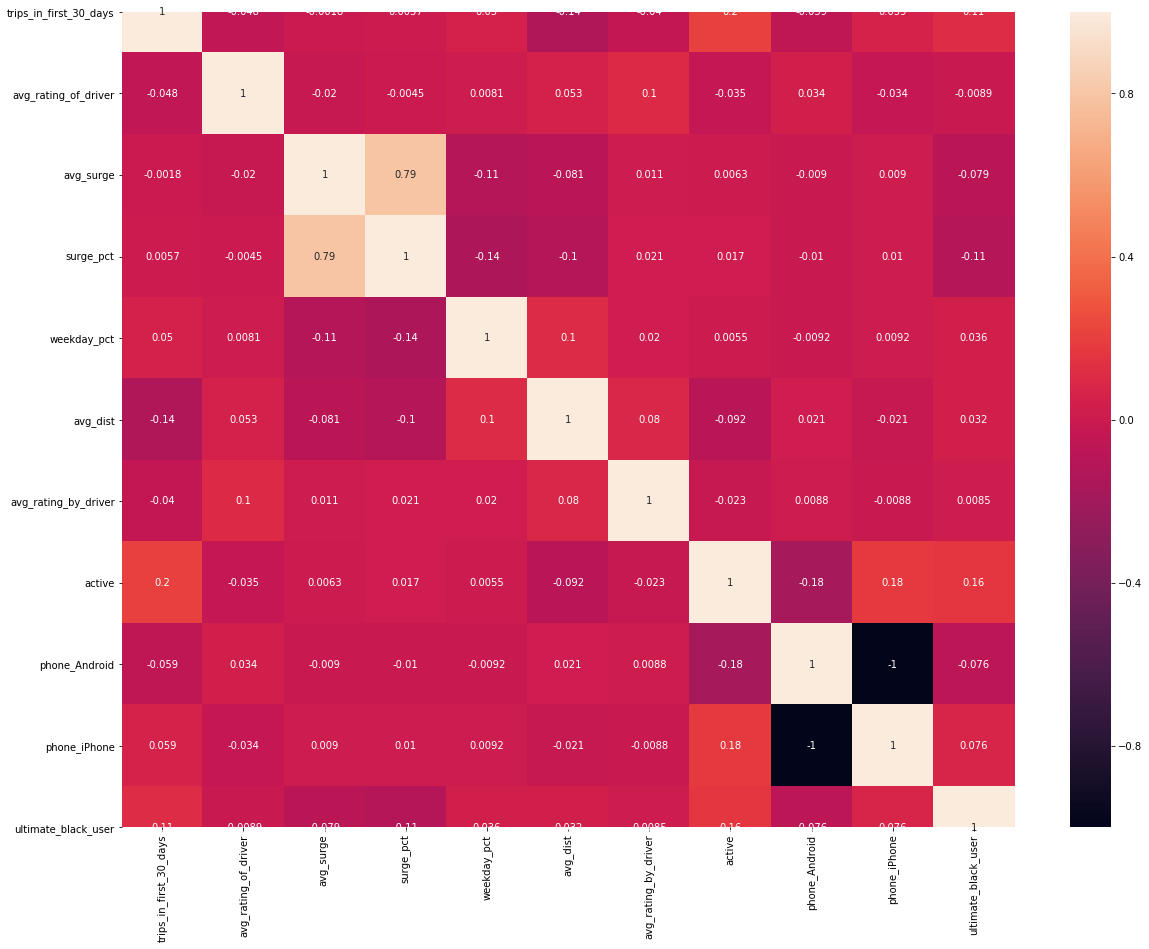

In [41]:
## Checking correlation between the independent and dependent variables

plt.figure(figsize=(20,15))
sns.heatmap(df_for_corr.corr(), annot= True)

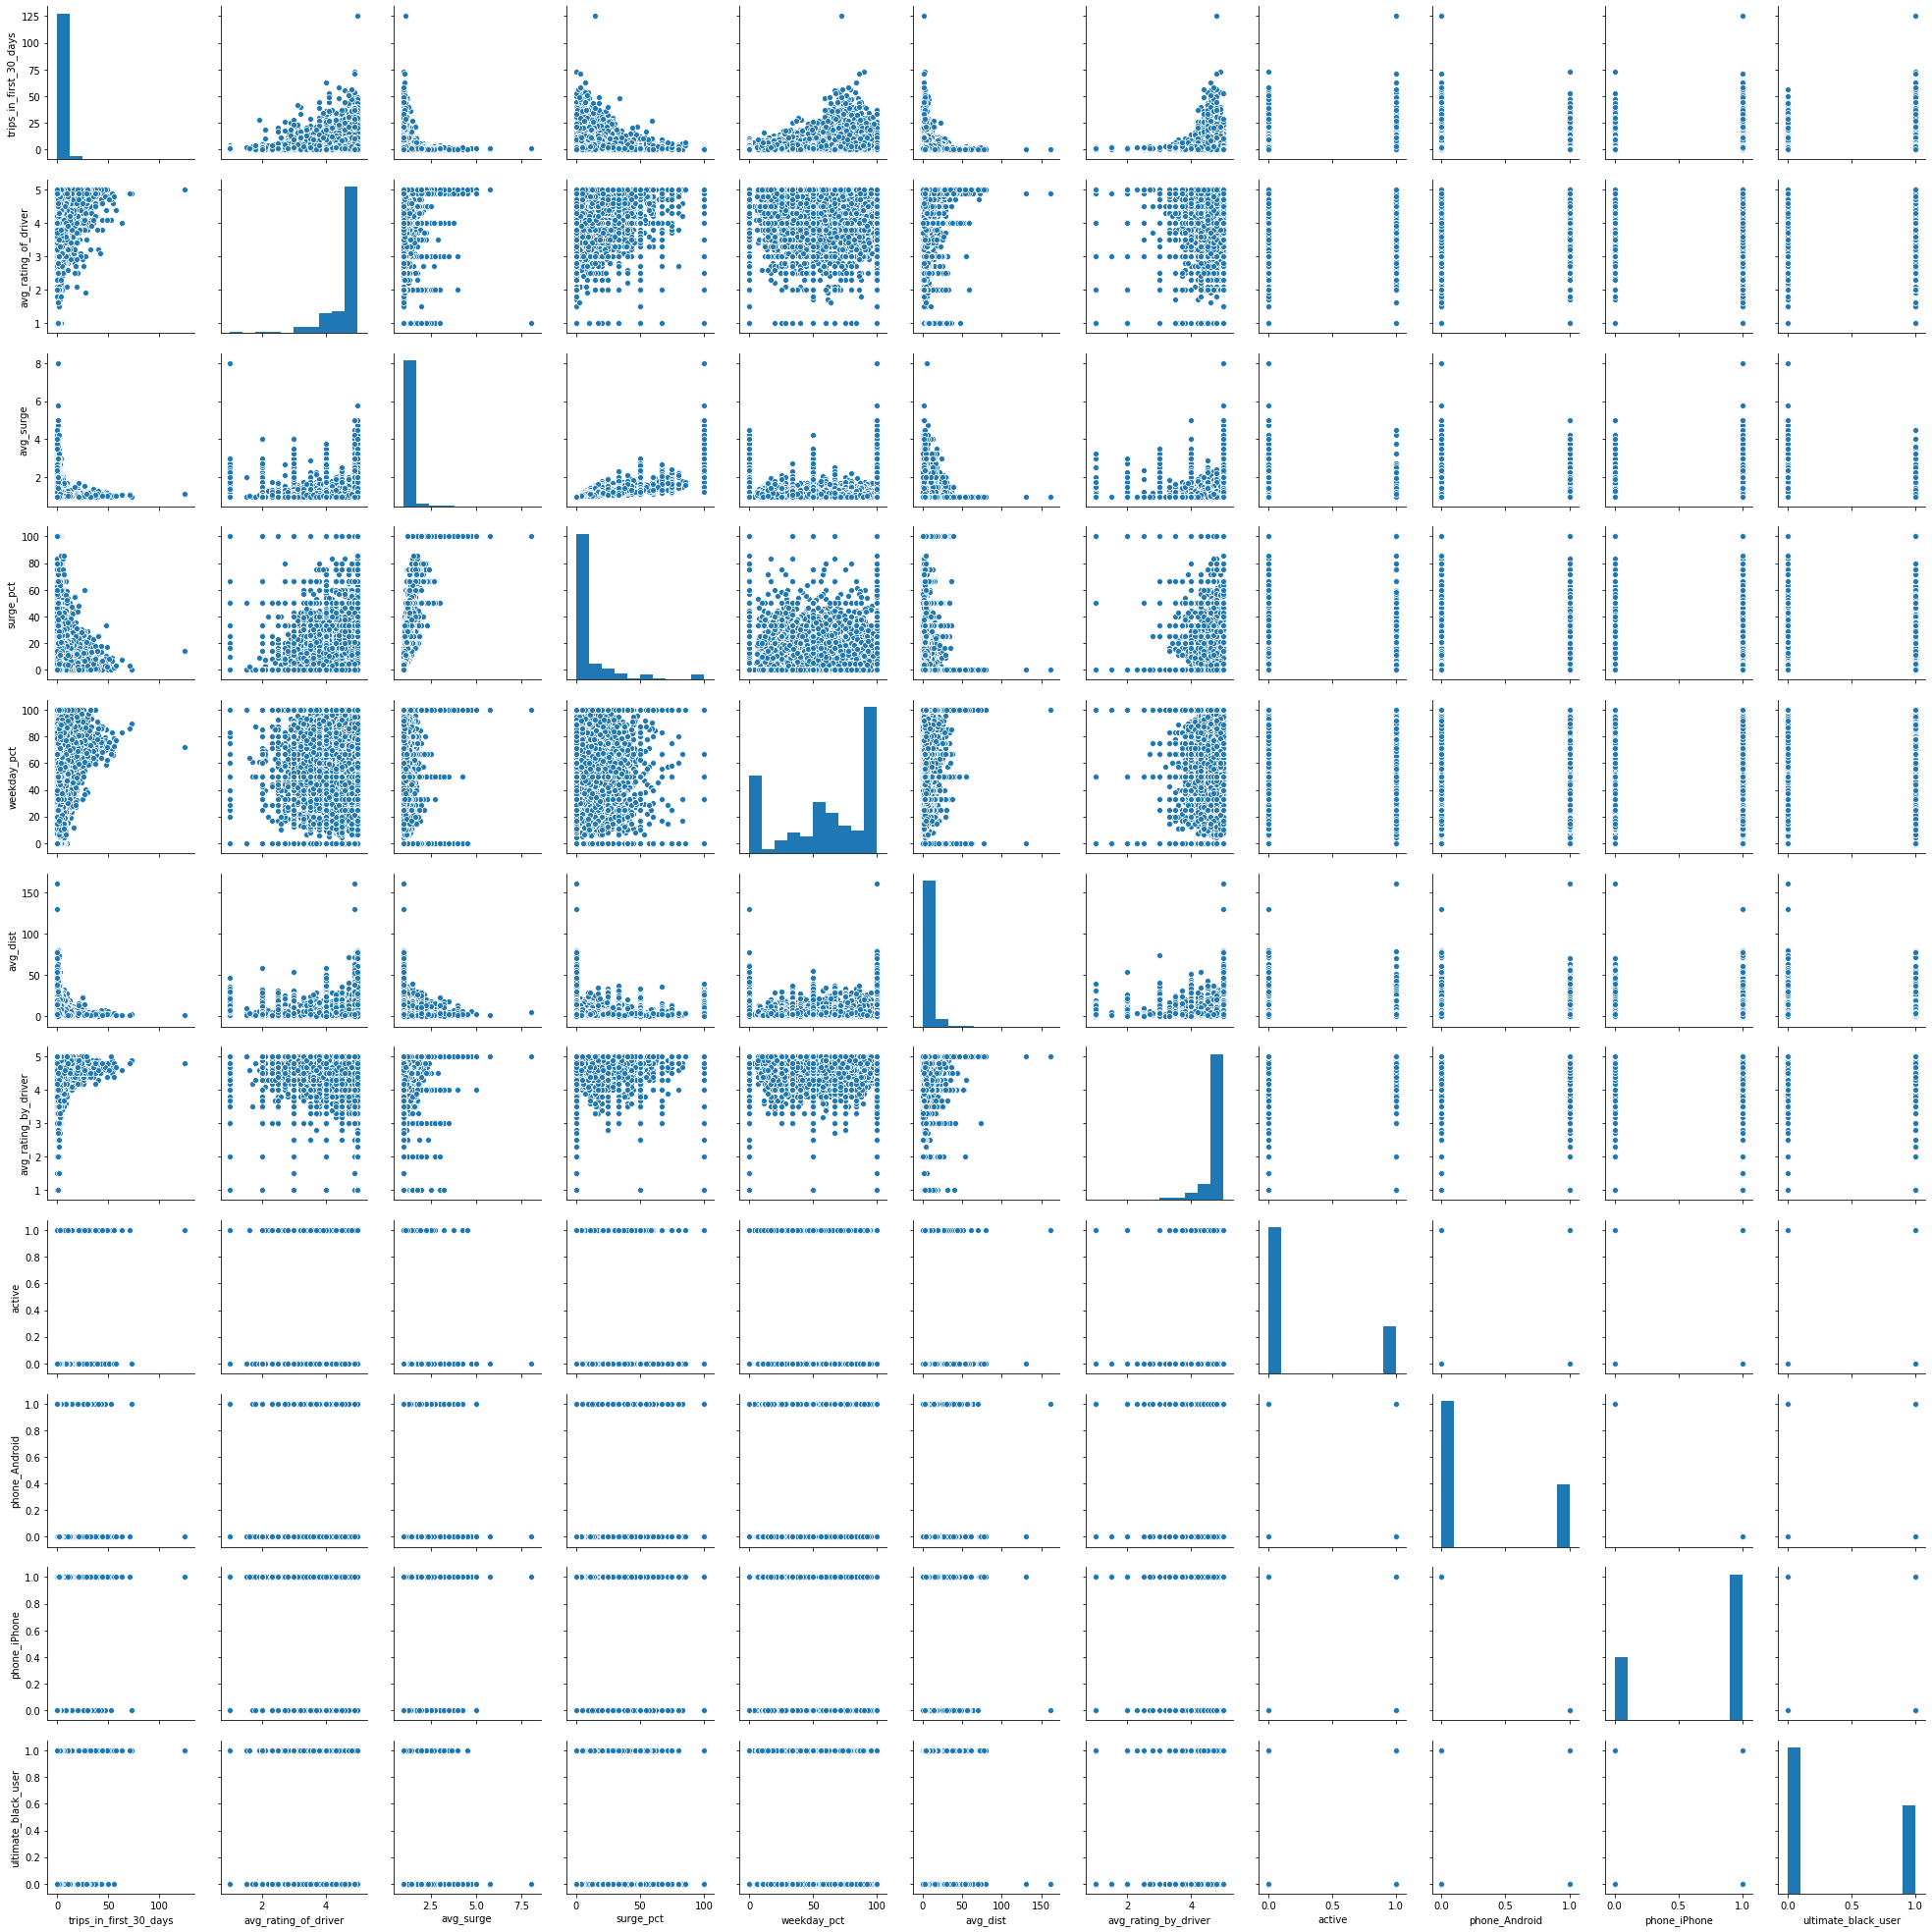

In [42]:
## Checking if the independent variables have a standard normal distribution or not

sns.pairplot(df_for_corr)
plt.show()

In [43]:
df_for_corr.drop(['phone_Android', 'phone_iPhone'], axis=1, inplace= True)
df_for_corr.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,active,ultimate_black_user
0,4,4.7,1.10,15.4,46.2,3.67,5.0,0,1
1,0,5.0,1.00,0.0,50.0,8.26,5.0,0,0
2,3,4.3,1.00,0.0,100.0,0.77,5.0,0,0
3,9,4.6,1.14,20.0,80.0,2.36,4.9,1,1
4,14,4.4,1.19,11.8,82.4,3.13,4.9,0,0


In [44]:
## Dealing with Categorical variables

df_for_corr['city']=ultimate_df['city']
df_for_corr['phone']= df_categorical['phone']

from sklearn import preprocessing
le1 = preprocessing.LabelEncoder()
le1.fit(['Astapor',"King's Landing",'Winterfell'])
le2= preprocessing.LabelEncoder()
le2.fit(['iPhone','Android'])

LabelEncoder()

In [45]:
city_transformed= le1.transform(df_for_corr['city'])
phone_transformed= le2.transform(df_for_corr['phone'])


In [46]:

df_city_transformed= pd.DataFrame(city_transformed, columns=['city_t'])
df_phone_transformed= pd.DataFrame(phone_transformed, columns= ['phone_t'])

In [47]:
df_final= pd.concat([df_for_corr, df_city_transformed, df_phone_transformed], axis= 1)
df_final.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,active,ultimate_black_user,city,phone,city_t,phone_t
0,4,4.7,1.10,15.4,46.2,3.67,5.0,0,1,King's Landing,iPhone,1,1
1,0,5.0,1.00,0.0,50.0,8.26,5.0,0,0,Astapor,Android,0,0
2,3,4.3,1.00,0.0,100.0,0.77,5.0,0,0,Astapor,iPhone,0,1
3,9,4.6,1.14,20.0,80.0,2.36,4.9,1,1,King's Landing,iPhone,1,1
4,14,4.4,1.19,11.8,82.4,3.13,4.9,0,0,Winterfell,Android,2,0


In [48]:
df_final.drop(['city', 'phone'], axis= 1, inplace= True)
df_final.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,active,ultimate_black_user,city_t,phone_t
0,4,4.7,1.10,15.4,46.2,3.67,5.0,0,1,1,1
1,0,5.0,1.00,0.0,50.0,8.26,5.0,0,0,0,0
2,3,4.3,1.00,0.0,100.0,0.77,5.0,0,0,0,1
3,9,4.6,1.14,20.0,80.0,2.36,4.9,1,1,1,1
4,14,4.4,1.19,11.8,82.4,3.13,4.9,0,0,2,0


In [49]:
# Normal Distribution

from sklearn.preprocessing import StandardScaler

scaler= StandardScaler()
scaler.fit_transform(df_final[['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge', 'surge_pct', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver', 'ultimate_black_user', 'city_t', 'phone_t']])

array([[ 0.45398382,  0.08680056,  0.11350592, ...,  1.28528485,
        -0.15414438,  0.65533957],
       [-0.60068878,  0.60800005, -0.33626828, ..., -0.77803765,
        -1.28722566, -1.52592647],
       [ 0.19031567, -0.60813209, -0.33626828, ..., -0.77803765,
        -1.28722566,  0.65533957],
       ...,
       [-0.60068878,  0.60800005, -0.33626828, ...,  1.28528485,
         0.97893691, -1.52592647],
       [-0.07335248, -2.86666322, -0.33626828, ..., -0.77803765,
        -1.28722566,  0.65533957],
       [-0.60068878,  0.43426689, -0.33626828, ..., -0.77803765,
        -1.28722566, -1.52592647]])

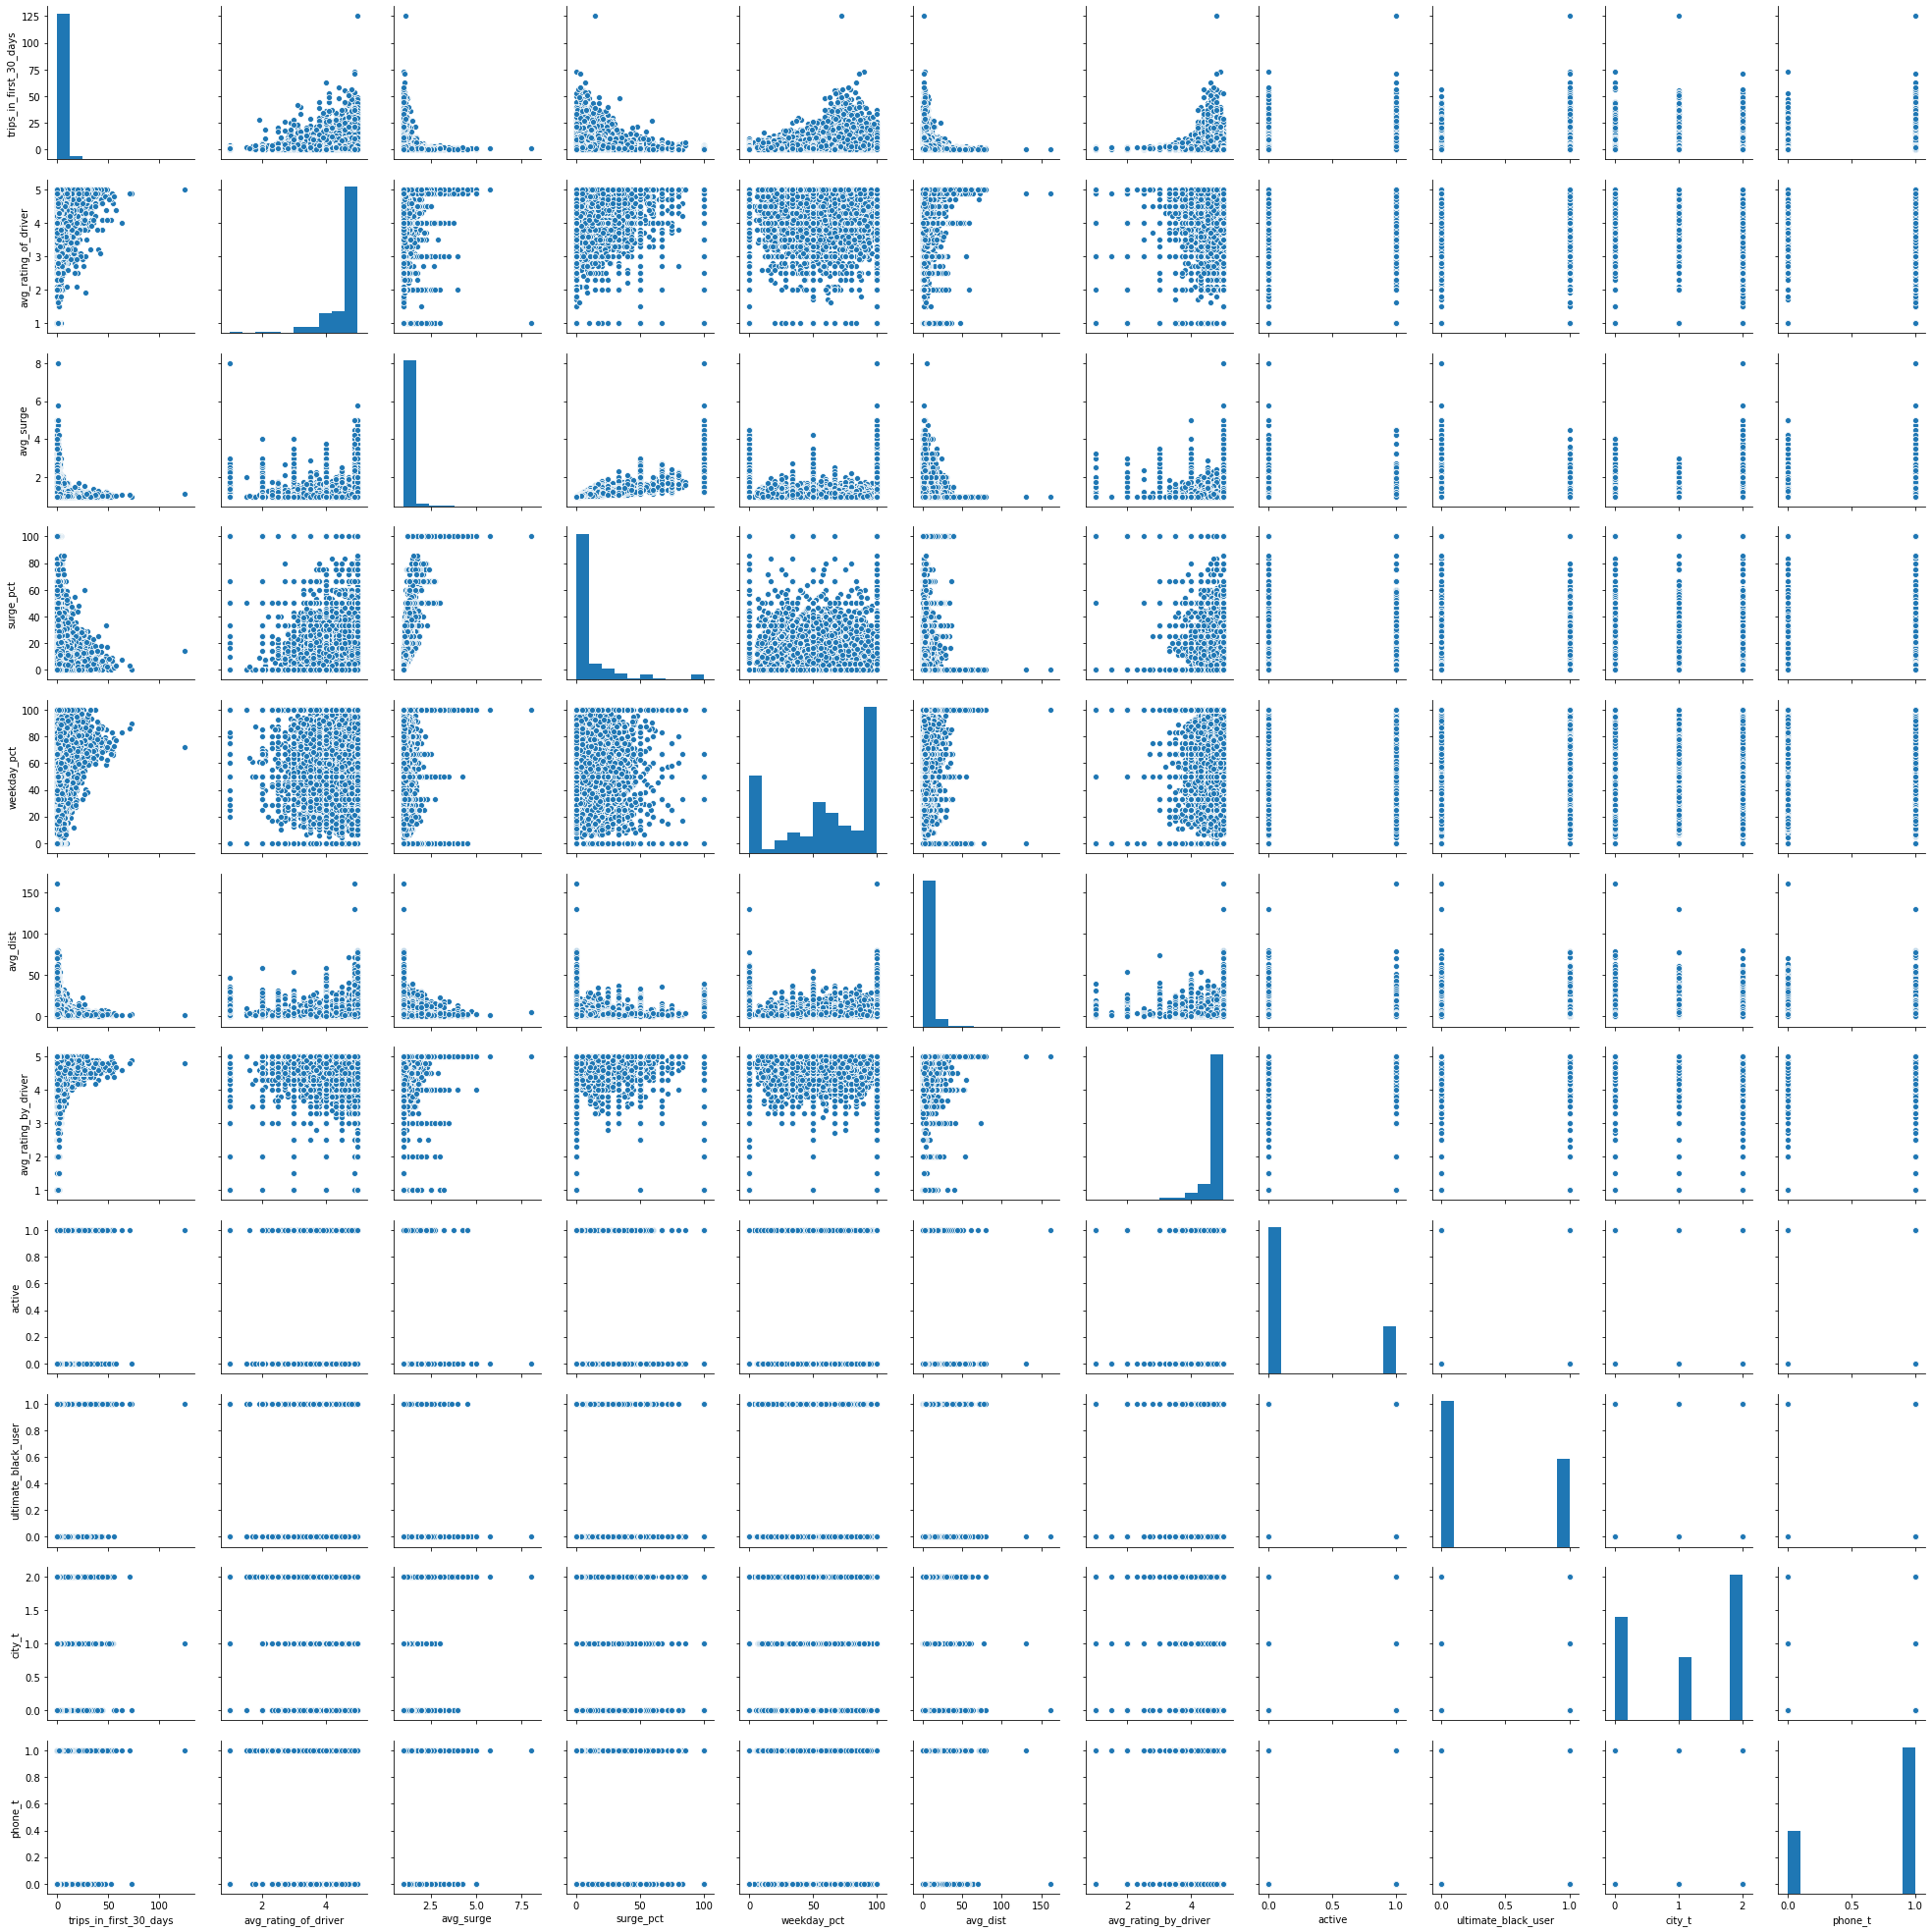

In [50]:
sns.pairplot(df_final)
plt.show()

In [51]:
y = df_final['active']
X = df_final[['avg_dist', 'avg_rating_by_driver','trips_in_first_30_days', 'city_t', 'phone_t','ultimate_black_user']]


X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= 0.3, random_state= 42)

log_reg= LogisticRegression()
log_reg.fit(X_train, y_train)

y_pred= log_reg.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[11081   252]
 [ 3265   402]]
              precision    recall  f1-score   support

           0       0.77      0.98      0.86     11333
           1       0.61      0.11      0.19      3667

    accuracy                           0.77     15000
   macro avg       0.69      0.54      0.52     15000
weighted avg       0.73      0.77      0.70     15000



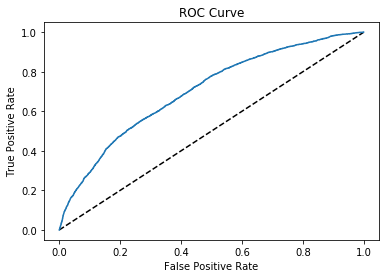

In [52]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = log_reg.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [53]:
# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

# Compute cross-validated AUC scores: cv_auc
cross_validation = cross_val_score(log_reg, X, y, cv = 5,scoring = 'roc_auc')

# Print list of AUC scores
print("AUC Score using 5-fold Cross-Validation: {}".format(cross_validation))

AUC: 0.7020308502472599
AUC Score using 5-fold Cross-Validation: [0.70115289 0.69652544 0.692629   0.70012439 0.70764857]


In [54]:
param_grid= {'C': np.logspace(-10, 10, 15)}
lr= LogisticRegression()

lr_cv= GridSearchCV(lr, param_grid, cv=5)
lr_cv.fit(X, y)

print("Tuned Parameters of the Logistic Regression: {}".format(lr_cv.best_params_))
print("Score (Best): {}".format(lr_cv.best_score_))

Tuned Parameters of the Logistic Regression: {'C': 1.0}
Score (Best): 0.7672599999999999


In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# fit model to training data
model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 78.43%


In [56]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Text(0, 0.5, 'Feature Importance Score')

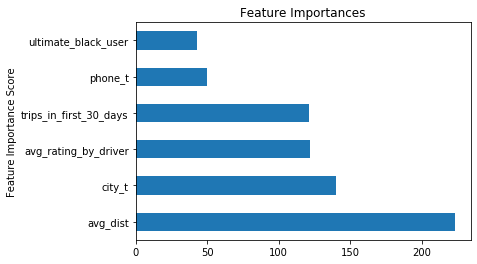

In [57]:
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='barh', title='Feature Importances')
plt.ylabel('Feature Importance Score')